#Object Detection Models
All of the <b>YOLO models are object detection models. Object detection models are trained to look at an image and search for a subset of object classes.</b> When found, these object classes are enclosed in a bounding box and their class is identified. Object detection models are typically trained and evaluated on the COCO dataset which contains a broad range of 80 object classes. From there, it is assumed that object detection models will generalize to new object detection tasks if they are exposed to new training data. Here is an example of me using YOLOv5 to detect helmet.

# How to Train YOLOv5

based on the [YOLOv5 repository](https://github.com/ultralytics/yolov5) by [Ultralytics](https://www.ultralytics.com/). This notebook shows training on **your own custom objects**. Many thanks to Ultralytics for putting this repository together - we hope that in combination with clean data management tools at Roboflow, this technologoy will become easily accessible to any developer wishing to use computer vision in their projects.

### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [how to train YOLOv5](https://blog.roboflow.ai/how-to-train-yolov5-on-a-custom-dataset/), concurrently.

### Steps needs to follow

we will walk through the steps required to train YOLOv5 on your custom objects. 

To train our detector we take the following steps:

* Install YOLOv5 dependencies
* Download custom YOLOv5 object detection data
* Write our YOLOv5 Training configuration
* Run YOLOv5 training
* Evaluate YOLOv5 performance
* Visualize YOLOv5 training data
* Run YOLOv5 inference on test images
* Export saved YOLOv5 weights for future inference



#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [2]:
# install dependencies as necessary
%cd /content/drive/MyDrive/Helment_Detection_Yolov5/yolov5/
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

/content/drive/MyDrive/Helment_Detection_Yolov5/yolov5
     |████████████████████████████████| 645kB 22.4MB/s 
Setup complete. Using torch 1.8.1+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


# Mount Google Drive 

We'll download our dataset from Roboflow. Use the "**YOLOv5 PyTorch**" export format. Note that the Ultralytics implementation calls for a YAML file defining where your training and test data is. The Roboflow export also writes this format for us.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# this is the YAML file we are loading into this notebook with our data
%cd /content/drive/MyDrive/Helment_Detection_Yolov5/
%cat data.yaml

/content/drive/MyDrive/Helment_Detection_Yolov5
train: ../train/images
val: ../valid/images

nc: 2
names: ['With Helmet', 'Without Helmet']

# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [4]:
# define number of classes based on YAML
import yaml
with open("/content/drive/MyDrive/Helment_Detection_Yolov5/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

![h](https://blog.roboflow.com/content/images/2020/06/yolov5-performance.png)

In [5]:
#this is the model configuration we will use for our tutorial 
%cat /content/drive/MyDrive/Helment_Detection_Yolov5/yolov5/models/yolov5l.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3,

#The Anatomy of an Object Detector

![layers](https://blog.roboflow.com/content/images/2020/06/image-10.png)

![layers](https://blog.roboflow.com/content/images/2020/06/image-11.png)

All **object detectors** *take an image in for input and compress features down through a convolutional neural network backbone*. In **image classification**, these backbones are the end of the network and prediction can be made off of them.

In **object detection**, multiple bounding boxes need to be drawn around images along with classification, so the feature layers of the convolutional backbone need to be mixed and held up in light of one another. The combination of backbone feature layers happens in the neck.

It is also useful to split object detectors into two categories: *one-stage detectors* and *two stage detectors*. Detection happens in the head. 

<b>Two-stage detectors decouple the task of object localization and classification for each bounding box.</b> 

<b>One-stage detectors make the predictions for object localization and classification at the same time.<b> *YOLO is a one-stage detector, hence, You Only Look Once*.

In [6]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [7]:
%%writetemplate /content/drive/MyDrive/Helment_Detection_Yolov5/yolov5/models/custom_yolov5l.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

#The Detection Step

![object](https://blog.roboflow.com/content/images/2020/06/image-18.png)

# Train Helment Detector YOLOv5

Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/drive/MyDrive/Helment_Detection_Yolov5/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data '../data.yaml' --cfg ./models/custom_yolov5l.yaml --weights '' --name yolov5s_results  --cache

/content/drive/MyDrive/Helment_Detection_Yolov5/yolov5
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 61 (delta 31), reused 37 (delta 25), pack-reused 4
Unpacking objects: 100% (61/61), done.
From https://github.com/ultralytics/yolov5
   1849916..955eea8  master            -> origin/master
   c9c95fb..0824388  study_activations -> origin/study_activations
github: ⚠️ WARNING: code is out of date by 118 commits. Use 'git pull' to update or 'git clone https://github.com/ultralytics/yolov5' to download latest.
YOLOv5 v4.0-126-g886f1c0 torch 1.8.1+cu101 CUDA:0 (Tesla K80, 11441.1875MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=True, cfg='./models/custom_yolov5l.yaml', data='../data.yaml', device='', entity=None, epochs=100, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], linear_lr=False, local_rank=-1, l

# Evaluate Custom YOLOv5 Detector Performance

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`. (If given no name, it defaults to `results.txt`.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
#%load_ext tensorboard
#%tensorboard --logdir runs

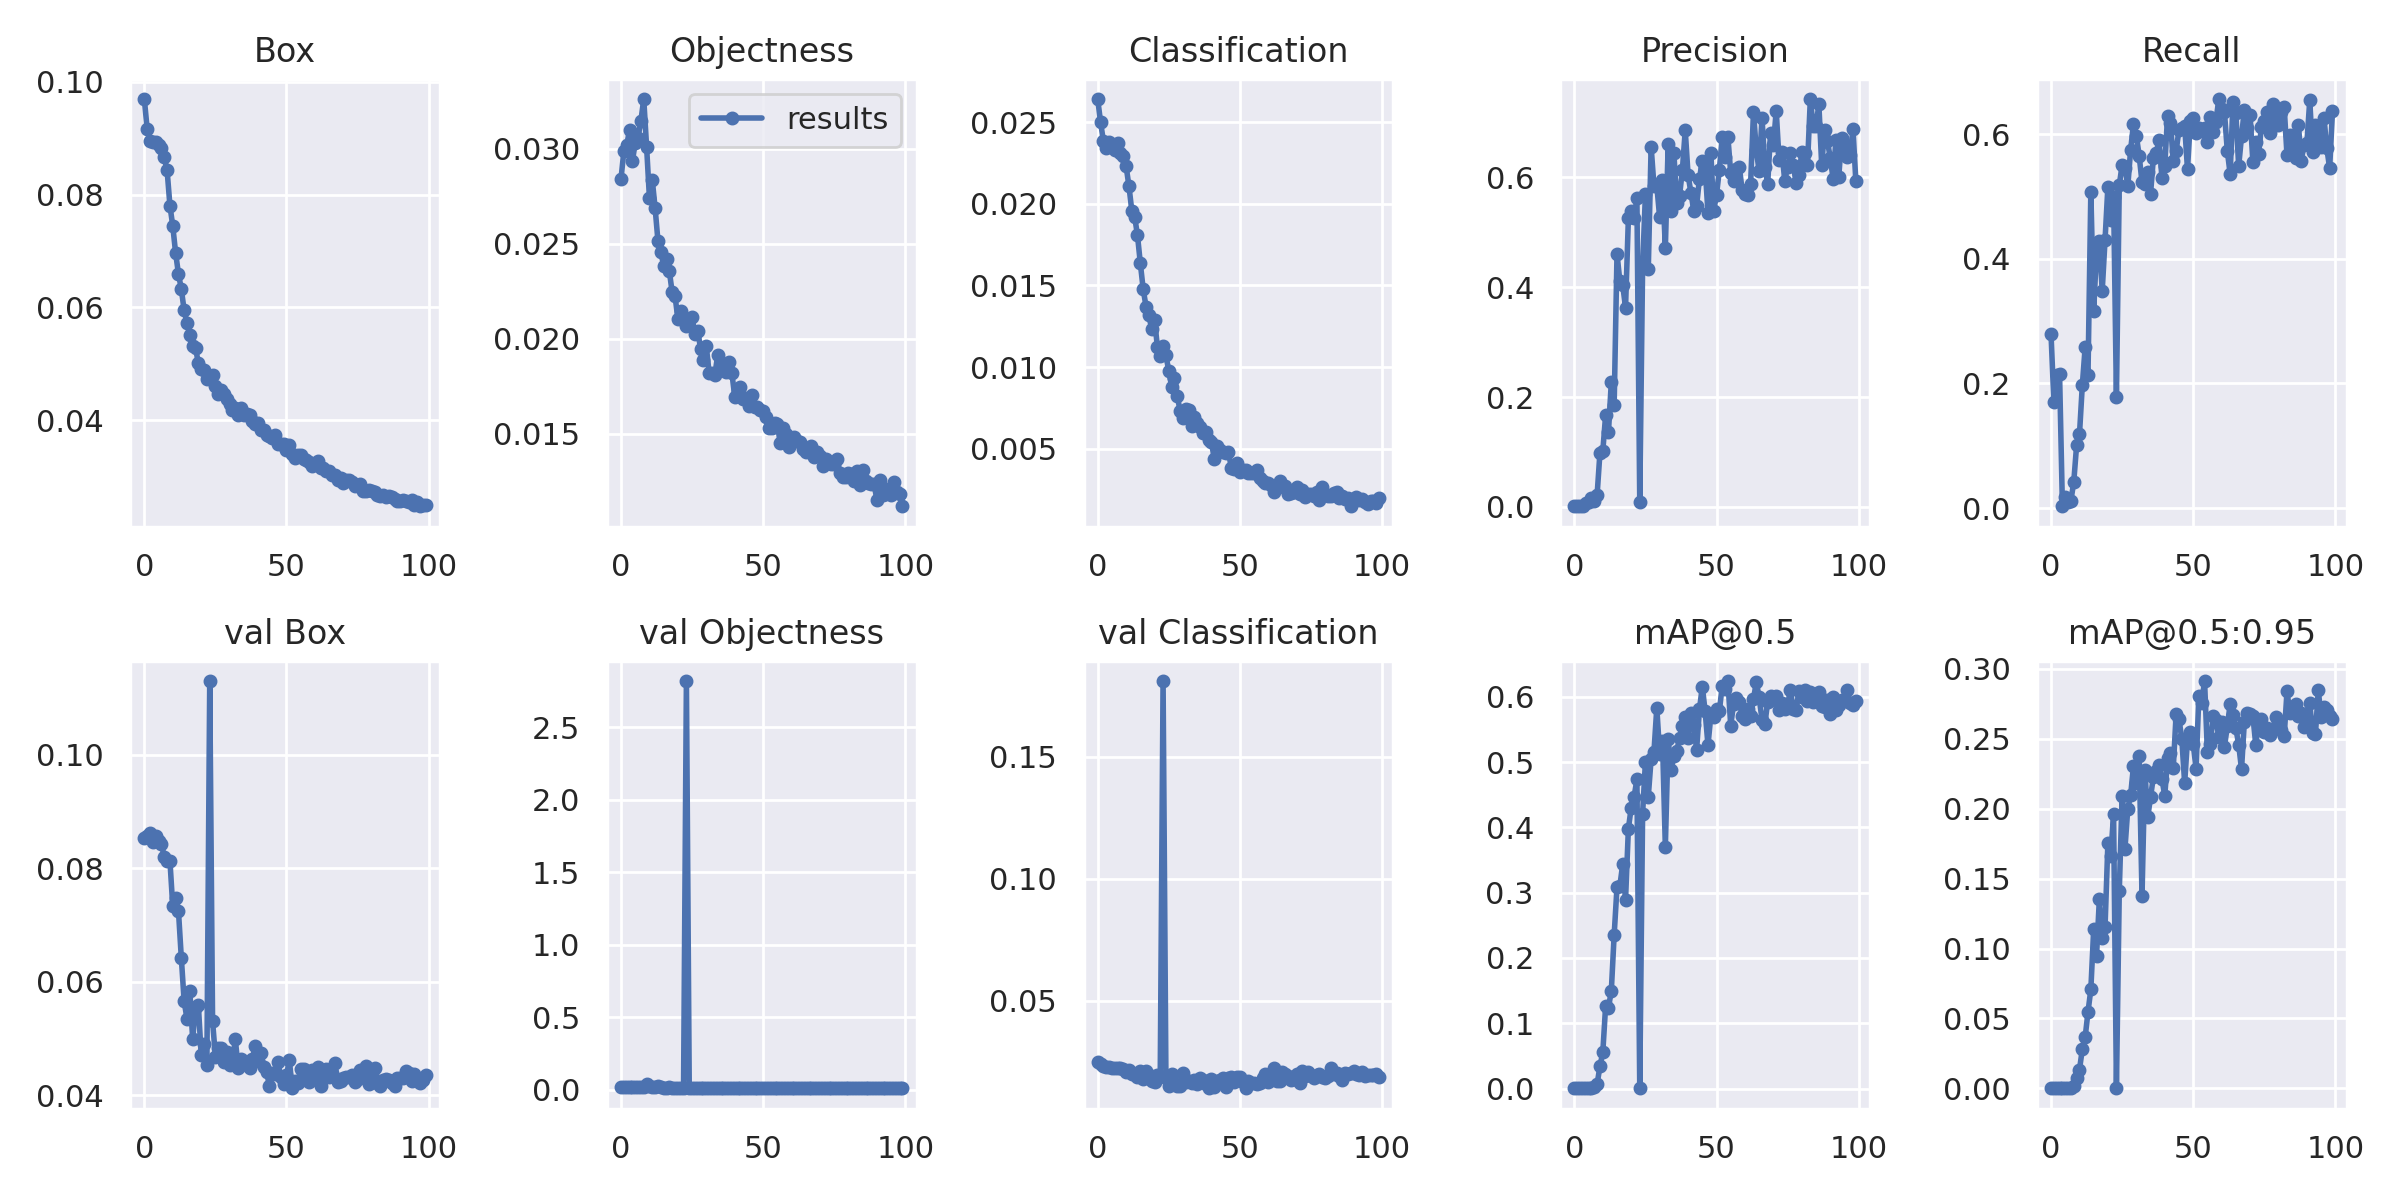

In [8]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/drive/MyDrive/Helment_Detection_Yolov5/yolov5/runs/train/yolov5s_results2/results.png', width=1000)  # view results.png
#Image(filename='/content/drive/MyDrive/Helment_Detection_Yolov5/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

GROUND TRUTH TRAINING DATA:


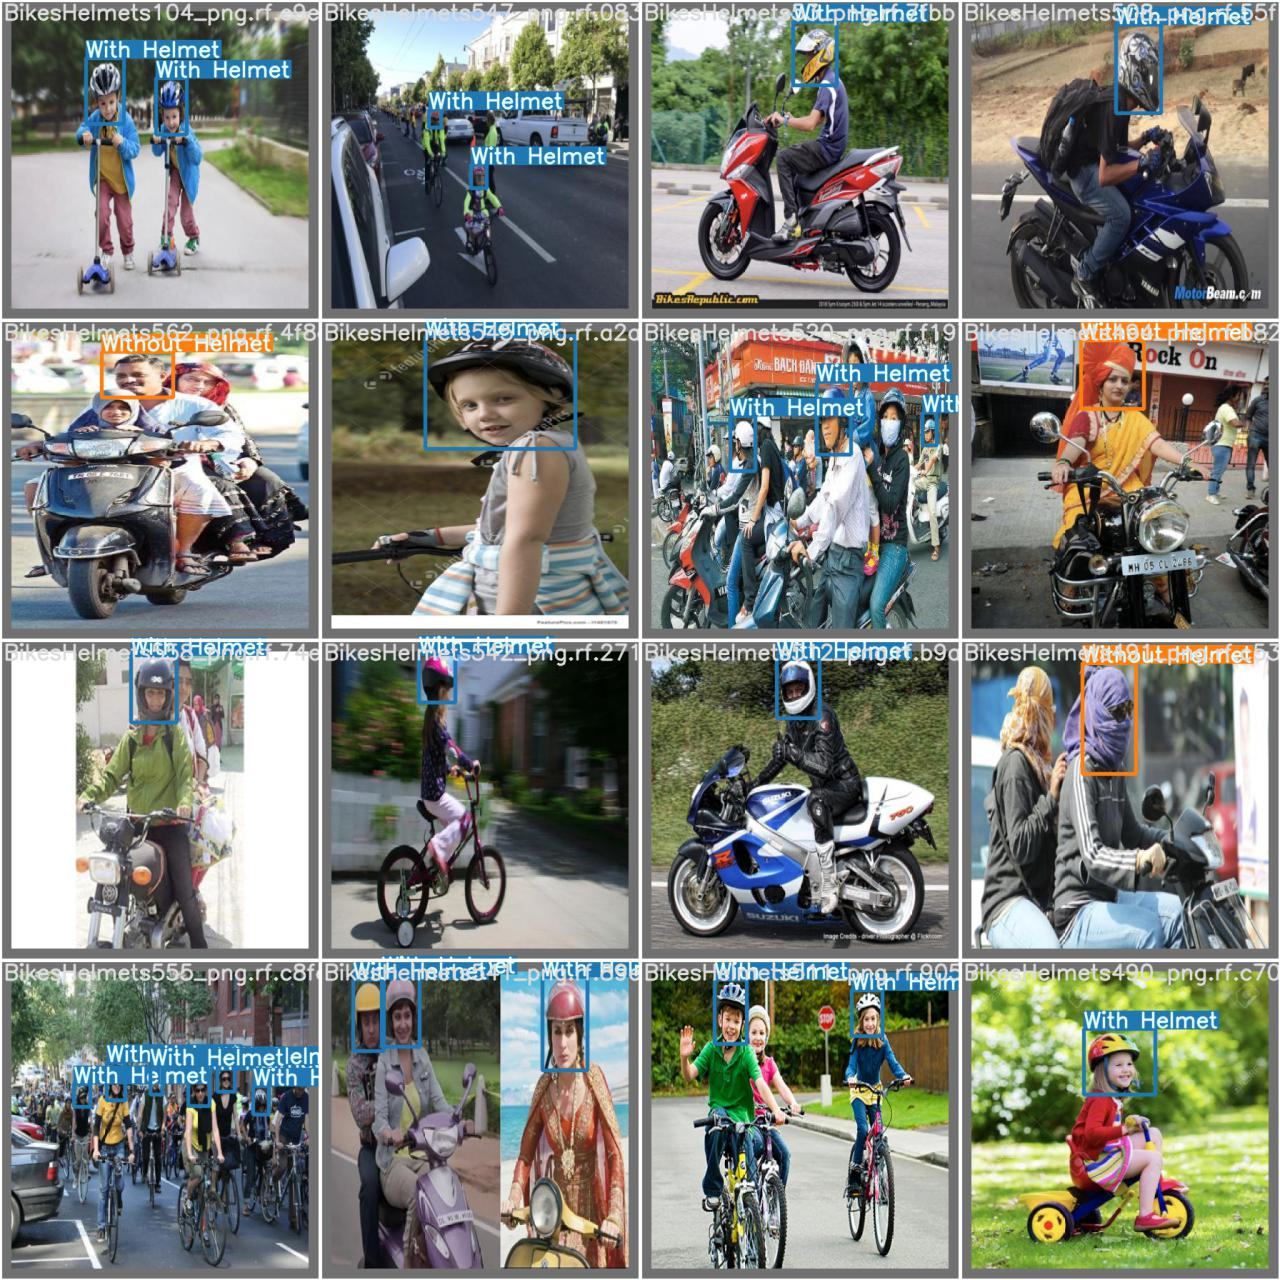

In [9]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/drive/MyDrive/Helment_Detection_Yolov5/yolov5/runs/train/yolov5s_results2/test_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


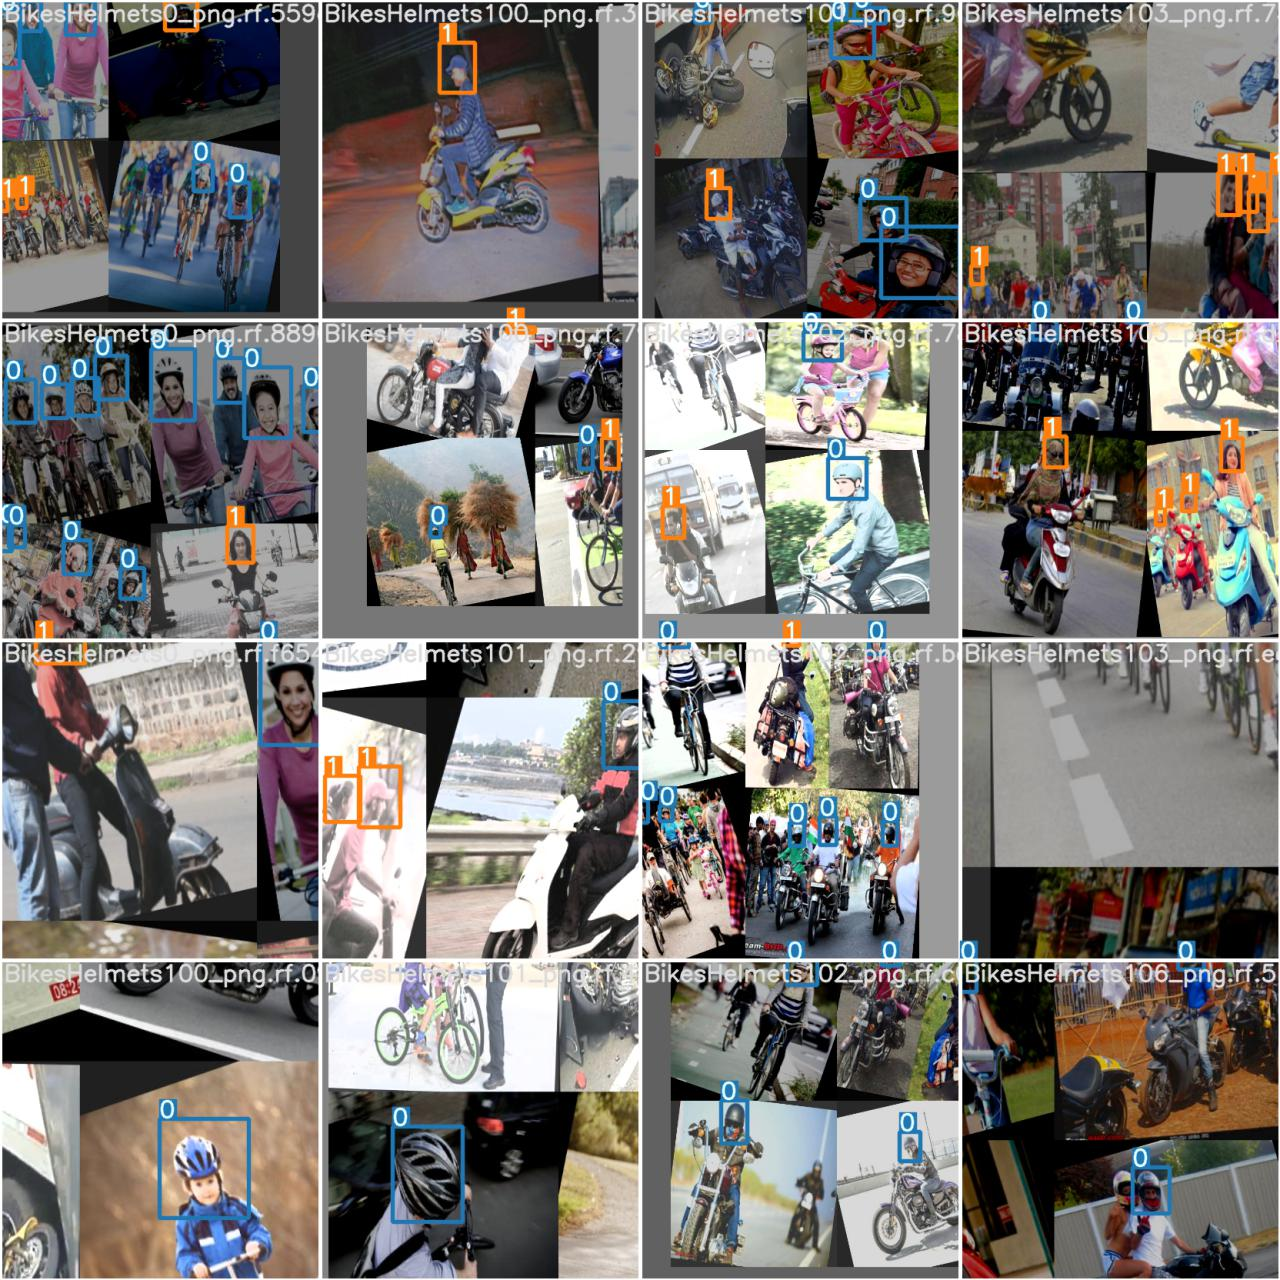

In [10]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/drive/MyDrive/Helment_Detection_Yolov5/yolov5/runs/train/yolov5s_results2/train_batch0.jpg', width=900)

#Run With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [12]:
# trained weights are saved by default in our weights folder
%cd /content/drive/MyDrive/Helment_Detection_Yolov5/yolov5/
%ls runs/

/content/drive/MyDrive/Helment_Detection_Yolov5/yolov5
detect/  train/


In [13]:
%ls runs/train/yolov5s_results2/weights

best.pt  last.pt


In [16]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /content/drive/MyDrive/Helment_Detection_Yolov5/yolov5/
!python detect.py --weights runs/train/yolov5s_results2/weights/last.pt --img 416 --conf 0.1 --source ../traffic
#!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source 0
#!python detect.py --weights runs/train/yolov5s_results2/weights/best.pt --conf 0.1 --source ../race/Men1.mp4

/content/drive/MyDrive/Helment_Detection_Yolov5/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.1, device='', exist_ok=False, img_size=416, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='../traffic', update=False, view_img=False, weights=['runs/train/yolov5s_results2/weights/last.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 392 layers, 46605951 parameters, 0 gradients, 114.1 GFLOPS
image 1/5 /content/drive/My Drive/Helment_Detection_Yolov5/yolov5/../traffic/traffic-helment13.jpg: 256x416 3 Without Helmets, Done. (0.022s)
image 2/5 /content/drive/My Drive/Helment_Detection_Yolov5/yolov5/../traffic/traffic-helment14.jpg: 256x416 8 With Helmets, 1 Without Helmet, Done. (0.021s)
image 3/5 /content/drive/My Drive/Helment_Detection_Yolov5/yolov5/../traffic/traffic-helment15.jpg: 288x416 3 With Helmets, 5 Without Helmets, Done. (0.021s)
image 4/5 /con

In [17]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/drive/MyDrive/Helment_Detection_Yolov5/yolov5/runs/detect/exp11/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

Output hidden; open in https://colab.research.google.com to view.

# Export Trained Weights for Future 

Now that you have trained your custom detector, you can export the trained weights you have made here for inference on your device elsewhere

In [ ]:
#%cp -r source destination

## References

Hope you enjoyed this!

1. [How to Train A Custom Object Detection Model with YOLO v5](https://towardsdatascience.com/how-to-train-a-custom-object-detection-model-with-yolo-v5-917e9ce13208)
2. [LabelImg is a graphical image annotation tool and label object bounding boxes in images](https://www.youtube.com/watch?v=p0nR2YsCY_U)
3. [How to Label Images for Object Detection with CVAT](https://www.youtube.com/watch?v=OMgQ2JzOAWA&t=601s)
4. [How to Train YOLO v5 on a Custom Dataset](https://www.youtube.com/watch?v=MdF6x6ZmLAY)
5. [Kaggle Dataset](https://www.kaggle.com/andrewmvd/helmet-detection/code)
6. [When Should I Auto-Orient My Images?](https://blog.roboflow.com/exif-auto-orientation/)
7. [YOLOv5 is Here: State-of-the-Art Object Detection at 140 FPS](https://blog.roboflow.com/yolov5-is-here/)
8. [To train YOLOv5, just drop in your dataset link from Roboflow.](https://models.roboflow.com/object-detection/yolov5)
9. [To get your data into Roboflow, follow the Getting Started Guide](https://blog.roboflow.ai/getting-started-with-roboflow/)
10. [Breaking Down YOLOv4](https://blog.roboflow.com/a-thorough-breakdown-of-yolov4/)
